# Анализ данных фитнес-центров

# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. <br>
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Задача заключается в проведении анализ и подготке плана действий по удержанию клиентов.

## Загрузка данных 

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц.

In [3]:
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;

Текущие поля в датасете: <br>
Данные клиента за предыдущий до проверки факта оттока месяц:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Для удобства приведем все названия колонок к единому формату:

In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропущенных строк в датафрейме нет. 

In [7]:
df.duplicated().sum()

0

Дубликатов не обнаружено.

### Вывод

Подготовили данные для дальнейшего анализа. 
Дубликатов, пропущенных значений обнаружено не было. 

## Исследовательский анализ данных (EDA)

Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения:

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Итак, на основании полученной таблицы можно сделать следующие выводы: 
- Gender: среднее значение 0.51, то есть женщин и мужчин примерно одинаковое количество
- Near_location: 0.84, у большинства людей зал расположен рядом с домом
- Partner: 0.48, половину посетителей составляют люди из компаний-партнёров
- Promo_friends: 0.31, примерно треть посетителей использовали промо-код от знакомого при оплате первого абонемента
- Phone: 0.9, у большинства из посетителей есть контактный телефон
- Contact_period: средняя длительность текущего действующего абонемента составляет около 5 месяцев (4,68)
- Group_visits: в среднем 41% посещают групповые занятия
- Age: средний возраст составляет 29 лет. Максимальный - 41 год, минимальный - 18. 
- Avg_additional_charges_total: Средняя суммарная выручка от других услуг фитнес-центра составляет 146,9. 
- Month_to_end_contract: Среднее количество месяцев до конца абонемента составляет 4.3 месяца
- Lifetime: Среднее время посещения фитнес-клуба - 3.7 месяцев
- Avg_class_frequency_total: в среднем (с начала действия абонемента) посетители ходят в зал примерно 2 раза в неделю (1.87)
- Avg_class_frequency_current_month: за последний месяц это значение составляет 1.76
- Churn: в текущем месяце показатели оттока - 26%.

Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [9]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Здесь интересна разница в средних значениях:
- partner: среди прекративших пользоваться абонементом этот показатель ниже (0.35 против 0.53), скорее всего, партнерские программы дают скидки на абонементы, поэтому их чаще продлевают (или реже прекращают)
- promo_friends: разница почти в 2 раза, быть может, это связано со скидками, или с положительными отзывами: вряд ли кто-то будет предлагать промо-код туда, где ему самому не нравится.
- contract_period и month_to_end_contract: средняя продолжительность абонементов и среднее количество месяцев до конца действия абонемента. Скорее всего, абонементы на бОльший срок, когда фитнес-клуб понравился.
- lifetime: тут почти то же самое, что и с продолжительностью действия абонемента. 4.7 месяцев против 0.99. Выходит, оттока больше среди новичков. 
- и последний показатель, среднее количество посещений в неделю: За последний месяц среди прекративших этот показатель ниже почти в 2 раза: 2.02 и 1.04. Выходит, чтобы не уйти из зала через месяц, надо ходить туда хотя бы пару раз в неделю!

Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

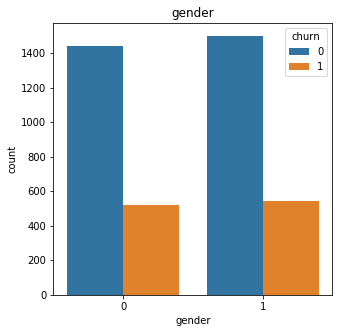

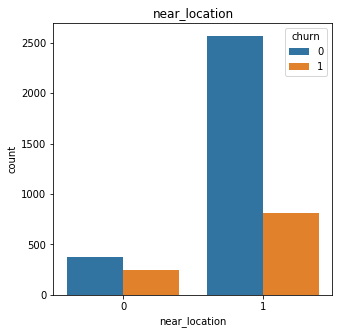

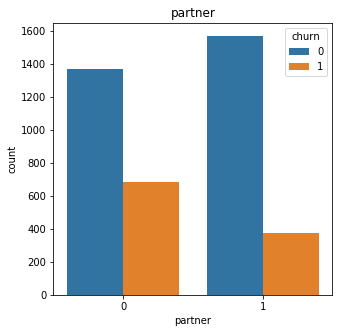

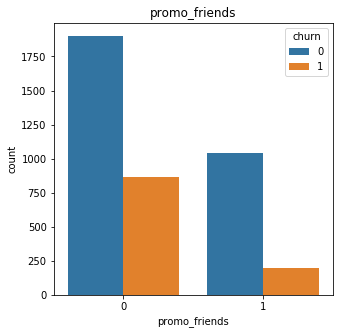

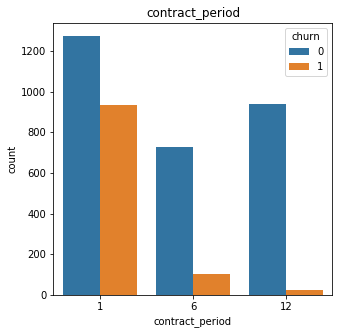

In [10]:
for column in ['gender'
               , 'near_location'
               , 'partner'
               , 'promo_friends'
               , 'contract_period'
               ]:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column]
                  , hue = 'churn'
                  , data = df)
    plt.title(column)
    plt.show()

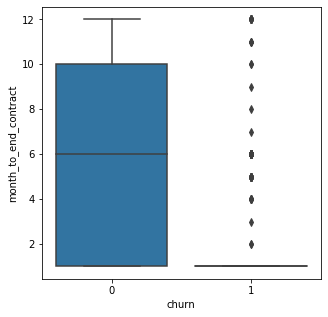

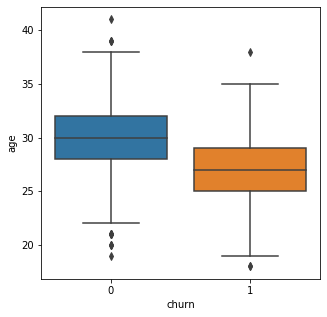

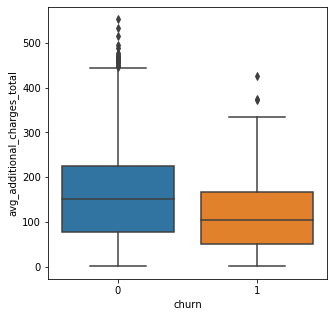

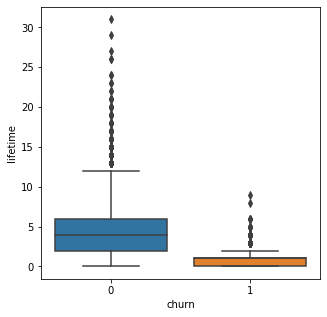

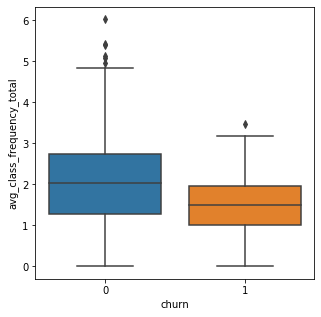

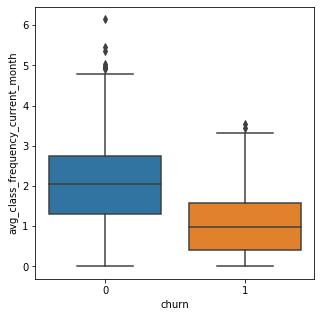

In [11]:
for column in ['month_to_end_contract'
               , 'age'
               , 'avg_additional_charges_total'
               , 'lifetime'
               , 'avg_class_frequency_total'
               , 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'churn'
                , y = df[column]
                , data = df)
    plt.show()

Постройте матрицу корреляций и отобразите её.

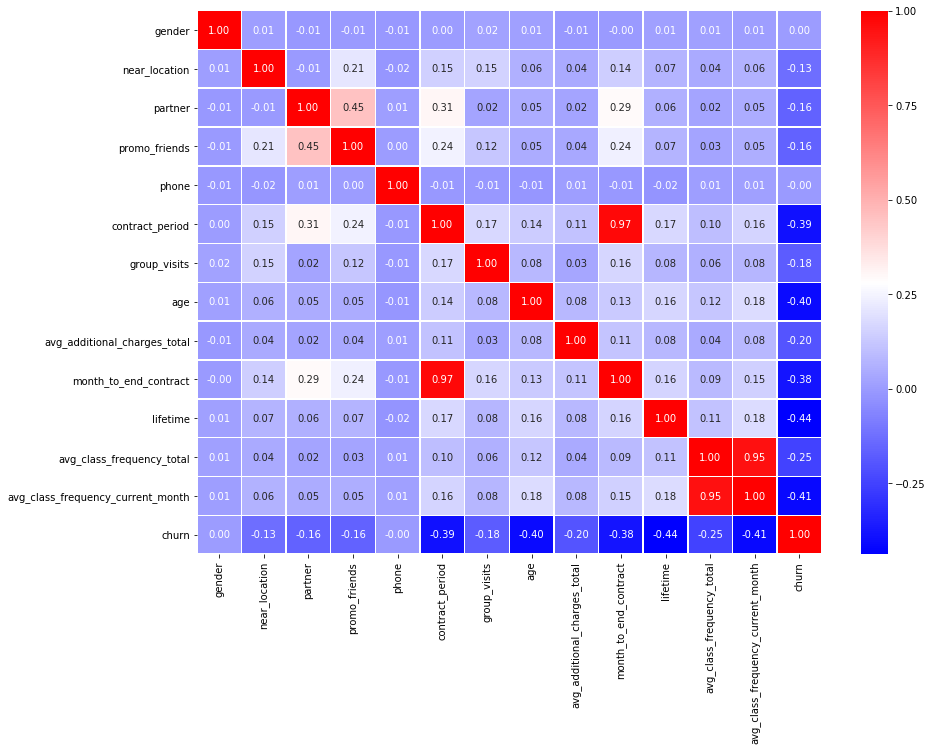

In [12]:
cm = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot = True, fmt = '0.2f', linewidths=.5, cmap = 'bwr')
plt.show()

Из матрицы корреляции видно, что на отток практически не влияет гендер (gender) и наличие контактного телефона (phone). <br>
Уменьшению оттока способствуют такие признаки, как:
- contact_period (бОльший срок действия абонемента)
- age (чем выше возраст)
- lifetime (чем дольше клиент пользуется услугами фитнес-клуба)
- среднее количество походов в неделю (чем оно выше, тем меньше вероятность, что клиент откажется от фитнеса)
<br>

Также есть мультиколлинеарные признаки: Contract_period / Month_to_end_contract и  Avg_class_frequency_current_month / Avg_class_frequency_total.


### Вывод

Проанализировали данные, построили стролбчатые гистрограммы  и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток); построили матрицу корреляции. 

Из матрицы корреляции видно, что на отток практически не влияет гендер и наличие контактного телефона.
По матрице определили, что уменьшению оттока способствуют такие признаки, как:
- contact_period (бОльший срок действия абонемента)
- age (чем выше возраст)
- lifetime (чем дольше клиент пользуется услугами фитнес-клуба)
- среднее количество походов в неделю (чем оно выше, тем меньше вероятность, что клиент откажется от фитнеса)

Также в данных есть мультиколлинеарные признаки: Contract_period / Month_to_end_contract и Avg_class_frequency_current_month / Avg_class_frequency_total.

## Построение модели прогнозирования оттока клиентов

Разбейте данные на обучающую и валидационную выборку функцией train_test_split().
Обучите модель на train-выборке двумя способами:
логистической регрессией, случайным лесом.
Оценим метрики accuracy, precision и recall для обеих моделей и сравним по ним модели.

Постром модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [13]:
X = df.drop('churn', axis = 1)
y = df['churn']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Логистическая регрессия

In [15]:
model = LogisticRegression()

In [16]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

In [18]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83
F1: 0.85


### Случайный лес

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [20]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.81
F1: 0.83


### Вывод

Обучили модель на train-выборке двумя способами: логистической регрессией, случайным лесом. 
На основании полученных метрик можно сделать вывод о том, что Логистическа регрессиия показывает себя лучше. 

## Кластеризация клиентов

Стандартизируем данные и нарисуем дендрограмму:

In [21]:
# обязательная стандартизация данных перед работой с алгоритмами
df_sс = df.drop(['churn'], axis=1)
df_columns_list = df_sс.columns
df_sс = StandardScaler().fit_transform(df_sс)
df_sс = pd.DataFrame(df_sс, columns = df_columns_list).astype('float64')

In [22]:
linked = linkage(df_sс, method = 'ward')

In [ ]:
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Оптимальное число кластеров, которое можно выделить - 5.  

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [ ]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(df_sс)
df['cluster'] = labels

In [ ]:
df.cluster.value_counts()

Посмотрим на средние значения параметров:

In [ ]:
df.groupby('cluster').mean().T

Отток 0 и 4 кластеров ниже, чем остальных.
Посмотрим на средние значения параметров этих кластеров:
- near_location - большинство клиентов проживают вблизи фитнес-клуба.
- lifetime - среднее количество месяцев близится к 5 (другие кластеры - около 3)
- group_visits - показатели также выше, чем в других кластерах
- среднее количество посещений в неделю
- расходы на дополнительные услуги также выше

На основании этого можно сделать вывод о том, что все эти показатели снижают вероятность оттока клиентов.



Посмотрим также на распределение этих признаков по кластерам:

In [ ]:
for column in ['gender'
               , 'near_location'
               , 'partner'
               , 'promo_friends'
               , 'contract_period'
               , 'phone']:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = df[column]
                  , hue = 'cluster'
                  , data = df)
    plt.title(column)
    plt.show()

In [ ]:
for column in ['month_to_end_contract'
               , 'age'
               , 'avg_additional_charges_total'
               , 'lifetime'
               , 'avg_class_frequency_total'
               , 'avg_class_frequency_current_month']:
    plt.figure(figsize=(5, 5))
    sns.boxplot(x = 'cluster'
                , y = df[column]
                , data = df)
    plt.show()

### Вывод

Стандартизировали данные, провели кластеризацию. Было выделено два "надежных" кластера (процент оттока там ниже). Проанализировали средние показатели в этих кластерах. 

## Общий вывод и базовые рекомендации по работе с клиентами

Проанализировали данные:
- Женщин и мужчин примерно одинаковое количество
- У большинства людей зал расположен рядом с домом
- Половину посетителей составляют люди из компаний-партнёров
- Примерно треть посетителей использовали промо-код от знакомого при оплате первого абонемента
- У большинства из посетителей есть контактный телефон
- Средняя длительность текущего действующего абонемента составляет около 5 месяцев (4,68)
- В среднем 41% посещают групповые занятия
- Средний возраст составляет 29 лет. Максимальный - 41 год, минимальный - 18.
- Средняя суммарная выручка от других услуг фитнес-центра составляет 146,9.
- Среднее количество месяцев до конца абонемента составляет 4.3 месяца
- Среднее время посещения фитнес-клуба - 3.7 месяцев
- В среднем (с начала действия абонемента) посетители ходят в зал примерно 2 раза в неделю (1.87)
- За последний месяц это значение составляет 1.76
- В текущем месяце показатели оттока - 26%.

На основании полученных данных сделали вывод о том, при увеличении каких признаков уменьшается вероятность оттока:
- близость дома к фитнес-клубу
- среднее количество месяцев с момента первого обращения в фитнес-центр 
- посещение групповых занятий
- среднее количество посещений в неделю
- расходы на дополнительные услуги

**Рекомендации по привлечению новых клиентов и удержанию старых:**
- проводить рекламные кампании с акцентом на близость фитнеса к дому
- предлагать скидки на долгосрочные абонементы, групповые занятия 
- каким-либо образом поощрять посетителей, которые ходят более двух раз неделю в спортзал (помочь сформировать привычку). Например, доп услугами - на третий раз в неделю дарить бесплатный напиток в кафе. Также это поможет клиенту ознакомиться с услугами, и вполне вероятно, он будет пользоваться ими и за деньги. 